# Homework: Python Basics

## Team Name: team_astro_1

## Team Members: 

Arianna Judith Paredes Quiñonez, 
Juliana Valverde, 
Adrián Manzaba Vélez, 
Jose Miguel Ramirez Fuenzalida, 

## Instructions and initial task:

The purpose of this assignment is to find the characteristic index of the turbulence energy cascade of a snapshot taken from a subsonic turbulence simulation. The spectrum scales, so for simplicity we will work in code units.

You should upload the following simulation file (turbulence_sub_hr.vtk) to your Drive:

https://github.com/ciencialatitud0/EPIC_2/tree/main/Day1/Basics-2/homework/homework_data

**Please work with your team mates and produce a single python notebook per group.** When you finish, ask one of the group members to place the notebook onto the EPIC 2 github repository (we recommend to fork the repository, add the notebook to the Day1/Basics-2/homework/ in your account, and then do a pull request).

To get you started I have added a few lines to open the VTK simulation file and make a plot. First, you should reproduce this on Google Colab.

### Reference: 

https://github.com/ciencialatitud0/EPIC_2/blob/main/Day1/Basics-2/2d_python_II_CFDdata.ipynb

In [1]:
# First let's mount our Drive folder:

from google.colab import drive
drive.mount('/content/drive')

# To display the contents

!ls "/content/drive/My Drive"

Mounted at /content/drive
 Certificados
'Colab Notebooks'
'Copia de Technology Project Proposal Minitheme by Slidesgo.gslides'
'CUMPLEAÑOS    90.docx'
'Documento sin título (1).gdoc'
'Documento sin título (2).gdoc'
'Documento sin título (3).gdoc'
'Documento sin título (4).gdoc'
'Documento sin título.gdoc'
 Evento.gdoc
'Firma Electrónica'
 Fotos
'Hoja de cálculo sin título.gsheet'
 MRAM.gslides
'Presentación Proyecto .gslides'
'Presentation RQM.gslides'
 Videos


In [3]:
# Then, we need to install pyvista
!pip install pyvista

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Import useful libraries

import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Indicate the working directory

input_directory="/content/drive/My Drive/Colab Notebooks/"
file_name = "turbulence_sub_hr.vtk"

In [ ]:
# Read the mesh

mesh = pv.read(input_directory+file_name)

print(mesh)

In [7]:
# Now, we read all the scalar and vector quantities

rho = pv.get_array(mesh, "rho", preference = 'cell') # density in code units
vx1 = pv.get_array(mesh, "vx1", preference = 'cell') # x velocity component in code units
vx2 = pv.get_array(mesh, "vx2", preference = 'cell') # y velocity component in code units
Bx1 = pv.get_array(mesh, "Bx1", preference = 'cell') # x magnetic field component in code units
Bx2 = pv.get_array(mesh, "Bx2", preference = 'cell') # y magnetic field component in code units

In [8]:
# The above arrays are 1D, so we need to make them 2D
# To check you can run: print(rho.shape)

rho_2D = rho.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
vx1_2D = vx1.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
vx2_2D = vx2.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
Bx1_2D = Bx1.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)
Bx2_2D = Bx2.reshape(mesh.dimensions[0] - 1, mesh.dimensions[1] - 1)

In [9]:
# Create a 2D grid using metadata information

x = np.linspace(mesh.bounds[0], mesh.bounds[1], mesh.dimensions[0] - 1)
y = np.linspace(mesh.bounds[2], mesh.bounds[3], mesh.dimensions[1] - 1)

X, Y = np.meshgrid(x, y)

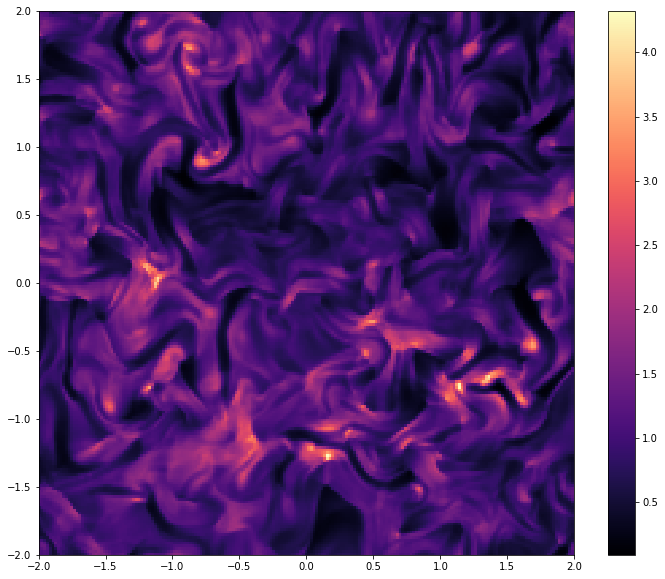

In [10]:
# And we are ready to interpolate our data onto the mesh:

plt.figure(figsize = (12,10))

Z = plt.pcolor(X, Y, rho_2D, cmap = 'magma')

plt.colorbar(Z)

plt.show()

# TASK 1:

Calculate the kinetic energy density and make a 2D map of it. Recall that:

$E_k =\frac{1}{2}\rho\,v^2$,

so you need to calculate the velocity modulus first:

$v=\sqrt{v_x^2+v_y^2}$.

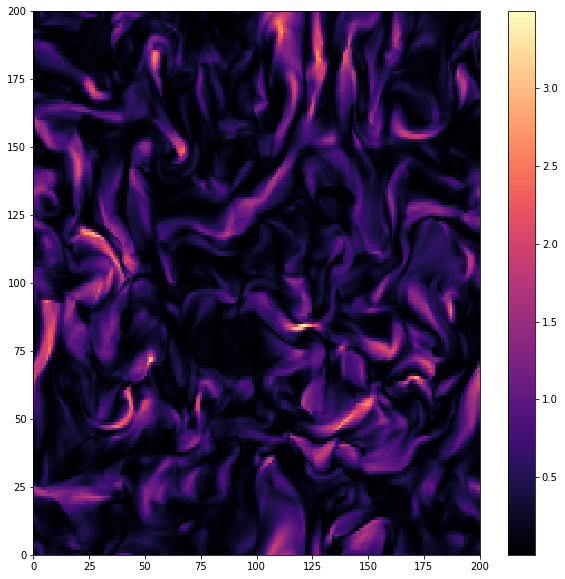

In [11]:
velocity = (vx1_2D**2 + vx2_2D**2)**(1/2)

def E_k(rho, v):
  E_k = (1/2)*rho*(v**2)
  return E_k

K_energy = E_k(rho_2D, velocity)

#Making the 2D map
plt.figure(figsize = (10,10))
map = plt.pcolor(K_energy, cmap = 'magma')
plt.colorbar(map)
plt.show()
  

# TASK 2: 

Carry out the 2D Fast Fourier Transform of the kinetic energy image that you produced above, and make a map of it.


### Reference:
https://github.com/ciencialatitud0/EPIC_2/blob/main/Day1/Basics-2/2b_fourier_transforms.ipynb

In [12]:
fourier_K = np.fft.fft2(K_energy)
shifted_fourier_K = np.fft.fftshift(fourier_K)
# Norms
norm_fourier_K = np.abs(fourier_K)
norm_shifted_K = np.abs(shifted_fourier_K)

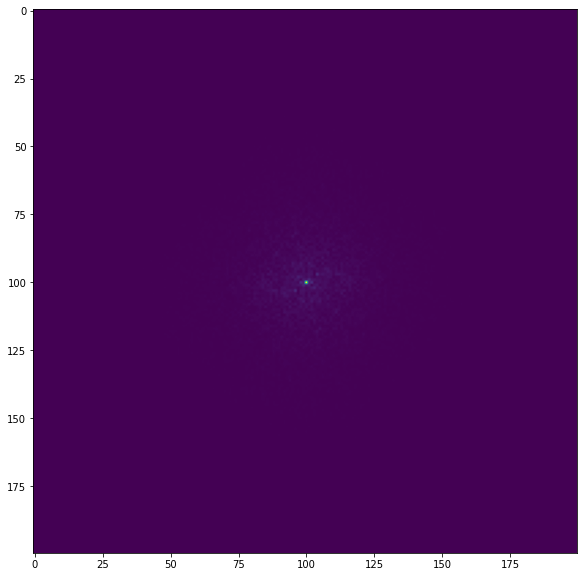

In [13]:
# Plotting Fourier image:
%matplotlib inline
plt.figure(figsize = (10,10))
plt.imshow(np.abs(shifted_fourier_K))

# TASK 3: 

Use the function below to produce a 1D Fourier spectrum from the 2D Fourier image that you produced above. Make a log-log plot of the 1D Fourier spetrum. You should get a plot similar to the sketch shown here (in the "cascade of turbulence" section):

https://github.com/ciencialatitud0/EPIC_2/blob/main/Day1/Basics-2/2c_python_II_lecture.ipynb

### Note:
The GetPSD1D() function calculates the azimuthal summation and will allow you to test whether the spectrum of this turbulence snaphot follows Kolmogorov or not.





In [14]:
from scipy import ndimage
import math

In [15]:
#===================================================================
# Get PSD 1D (total radial power spectrum)
#===================================================================
def GetPSD1D(psd2D):
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h, 0:w]
    r    = np.hypot(X - wc, Y - hc).astype(np.int)

    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    psd1D = ndimage.sum(psd2D, r, index=np.arange(0, wc))

    return psd1D
#===================================================================

# Taken from: https://medium.com/tangibit-studios/2d-spectrum-characterization-e288f255cc59

In [18]:
d_spacing = (mesh.bounds[1] - mesh.bounds[0])/(mesh.bounds[0] - 1)

freqs_x = np.fft.fftfreq(K_energy.shape[0], d=d_spacing)

freqs_y = np.fft.fftfreq(K_energy.shape[1], d=d_spacing)

freqs_X, freqs_Y = np.meshgrid(sorted(freqs_x), sorted(freqs_y))

freqs_2X = GetPSD1D(np.abs(freqs_X))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


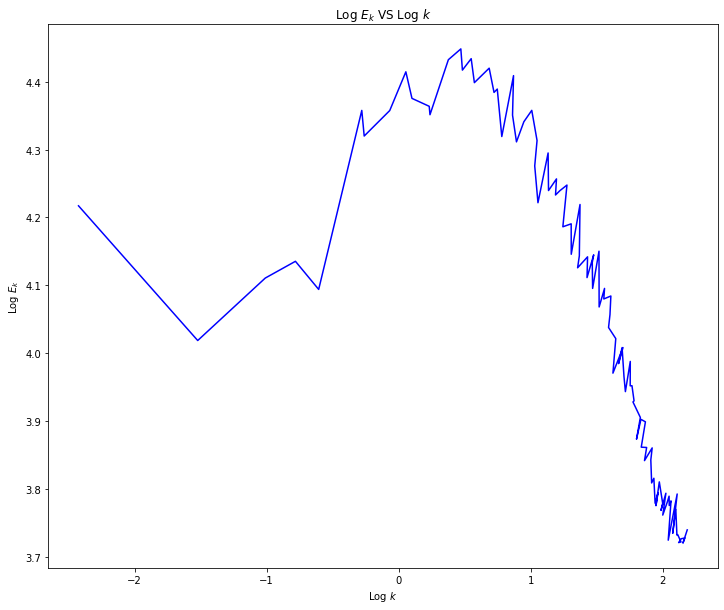

In [32]:
psd1D_E_k = GetPSD1D(np.abs(norm_shifted_K))

# Make plot
fig,ax=plt.subplots(1,1, figsize=(12, 10))

ax.plot(np.log10(freqs_2X), np.log10(psd1D_E_k), c='blue')
ax.set_title(r'Log $E_k$ VS Log $k$')
ax.set_xlabel(r'Log $k$')
ax.set_ylabel(r'Log $E_k$')
plt.show()

# TASK 4: 

Now that you have produced the 1D Fourier spectrum of the kinetic energy, label the plot identifying the turbulence generation, transfer, and dissipation regions. Finally, carry out a linear regression considering only the points associated with the inertial range. Does the spectrum follow Kolmogorov spectrum, $E_k \propto k^{-\frac{5}{3}}$?

### Reference:

https://github.com/ciencialatitud0/EPIC_2/blob/main/Day1/Basics-1/Sesion_1_Data_analysis_with_PythonI.ipynb

In [33]:
#Define a funtion for calculating the coefitiens for linear regration
def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)
  
    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)
  
    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
  
    # calculating regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x
  
    return (b_0, b_1)

In [34]:
#Define a funtion to plot the data and the linear regration
def plot_regression_line(x, y, b):
    # plotting the actual points as scatter plot
    plt.scatter(x, y, color = "m",
               marker = "o", s = 10)
  
    # predicted response vector
    y_pred = b[0] + b[1]*x
  
    # plotting the regression line
    plt.plot(x, y_pred, color = "g")
  
    # putting labels
    plt.xlabel(r'$\log{10},Ek$ versus $\log{10},\lambda$')
    plt.ylabel(r'$\log{10},k$')

    plt.ylim([3.7, 4.5])
  
    # function to show plot
    plt.show()

In [35]:
arreglo=np.log10(freqs_2X)[35:100]
E_k_mod=np.log10(psd1D_E_k)[35:100]

In [36]:
coef=estimate_coef(arreglo,E_k_mod)
print(coef)

(4.955840581537634, -0.5783187819835713)


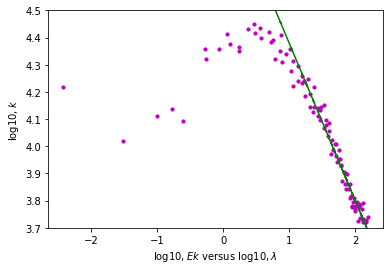

El valor de la pendiente es 
-0.5783187819835713
El valor mínimo de log_10(k) es: 
1.2435341018320618
El valor máximo de log_10(k) es: 
2.1858395150042353


In [37]:
plot_regression_line(np.log10(freqs_2X),np.log10(psd1D_E_k),coef)
print("El valor de la pendiente es ")
print(coef[1])
print("El valor mínimo de log_10(k) es: ")
print(min(np.log10(freqs_2X)[35:100]))
print("El valor máximo de log_10(k) es: ")
print(max(np.log10(freqs_2X)[35:100]))

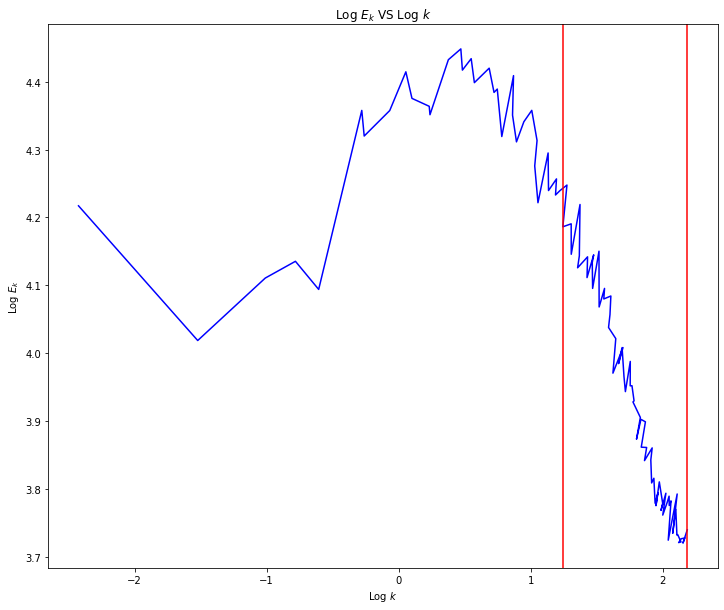

In [49]:
fig,ax=plt.subplots(1,1, figsize=(12, 10))

ax.plot(np.log10(freqs_2X), np.log10(psd1D_E_k), c='blue')
ax.set_title(r'Log $E_k$ VS Log $k$')
ax.set_xlabel(r'Log $k$')
ax.set_ylabel(r'Log $E_k$')

plt.axvline(x=1.2435341018320618, ymin=0, ymax=4.5, c='red')

plt.axvline(x=2.1858395150042353, ymin=0, ymax=4.5, c='red')

plt.show()

In the figure we can see the turbulence generation, transfer, and dissipation regions, respectively from the left.